In [12]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob
from itertools import chain


from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [13]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1

p["figure.figsize"] = (6.5*CM_PER_INCH, 5*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.2
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.85
p['figure.subplot.bottom'] = 0.28

In [14]:
def process(filename, headers, datas):
    header = np.loadtxt(filename, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, V_grill = header
    headers.append(header)

    data = np.loadtxt(filename, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append(np.array((V_in, I_out)))

In [15]:
all_headers = [[]]
all_datas = [[]]
for run in ["../data/hist2.tsv"]:
    process(run, all_headers[0], all_datas[0])

# sort all datasets by specific key
for i, (headers, datas) in enumerate(zip(all_headers, all_datas)):
    all_headers[i], all_datas[i] = zip(*sorted(zip(headers, datas), key=lambda c: c[0][-1]))

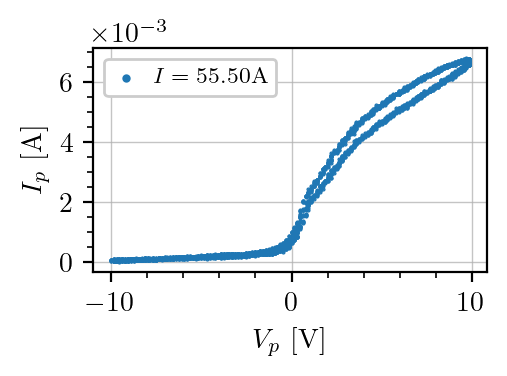

In [16]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
plt.ticklabel_format(axis='both', style='scientific', scilimits=(-2,2))

for header, data in zip(headers, datas):
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    V_in, I_out = data

    plt.scatter(V_in, (I_out), label=f"$I = {I_chauffage:.2f}$A")
    idx = I_out < 0
    # plt.scatter(V_in[idx], I_out[idx])
    plt.legend(ncols=3, fontsize=8, markerscale=4, loc="upper left", columnspacing=0.5)

plt.savefig("../figures/hysteresis.pdf")